### Random walks and image segmentation

Via simple examples we visualise the use of random walks for image segmentation<!-- .slide: data-fullscreen -->

At the beginning, images are represented as a grid networks of pixels, each one having a color value. 

By making the walkers avoid neighbour pixels that are too `different` from the one they're on, we are forcing them to stay in the same region of the image, thus segmenting it.


In [119]:
import random as rand

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from PIL import Image

Let's look at the benckmark image seen in class, a B29 Stratofortress flying over a cloudy sky: can we automatically detect it?

That is image 3096 the [Berkley Segmentation Dataset and Benchmark](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/)

The image below (a JPG version of the original PNG image) is $481\times 321=154,401$ pixels in size.


 A simplified dataset it the [BSD68 benckmark dataset](https://github.com/clausmichele/CBSD68-dataset/tree/master) which is a collection of images with a ground truth-segmentation mask that is used to benchmark *denoising*

![](https://raw.githubusercontent.com/clausmichele/CBSD68-dataset/master/CBSD68/groundtruth/airplane.png)

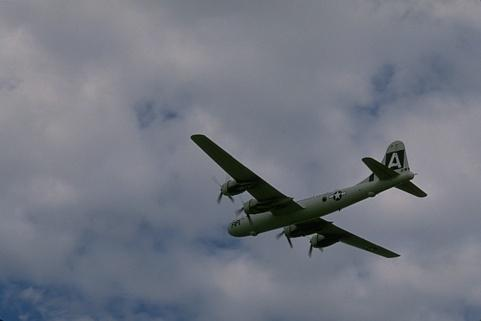

Find the original image and some example segmentations at [eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/3096.html](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/3096.html)

The random walks are started from a set of `seed` pixels, which are the ones we want to keep in the same segment.

In [120]:
IMGFILE = './imgs/0000.png'
bitmap = Image.open(IMGFILE)
matrix = np.array(bitmap)

print(matrix.shape)

(321, 481, 3)


In [121]:
shape_2d = matrix.shape[:2]
n_rows, n_cols = shape_2d

In [122]:
transitions = {}
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [123]:
# Loop through each element
for row in range(n_rows):
    for col in range(n_cols):
        neighbors = []
        for dir_row, dir_col in directions:
            next_row, next_col = row + dir_row, col + dir_col
            # Check if neighbor is within bounds
            if 0 <= next_row < n_rows and 0 <= next_col < n_cols:
                neighbors.append((next_row, next_col))
        transitions[(row, col)] = neighbors

In [124]:
rgb_sum = matrix.astype(np.float32).sum(axis=2)
norm = (1 / np.sqrt(3)) * np.sqrt(rgb_sum / 255)

In [125]:
diff_dict = {}

for (row, col), neighbors in transitions.items():
    current_norm = norm[row, col]
    diffs = []
    for neighbor_row, neighbor_col in neighbors:
        neighbor_norm = norm[neighbor_row, neighbor_col]
        diff = abs(current_norm - neighbor_norm)
        diffs.append(diff)
    diff_dict[(row, col)] = diffs

In [126]:
normalized_diff_dict = {}
epsilon = 1e-8

for key, diff_list in diff_dict.items():
    diff_array = np.array(diff_list, dtype=np.float32)

    # Invert differences → small diff = high score
    score_array = np.round(1.0 / (diff_array + epsilon), 2)

    total = score_array.sum()
    prob_array = score_array / total
    normalized_diff_dict[key] = prob_array.tolist()

In [127]:
counter_dict = {elem: 0 for elem in transitions}
pixels = list(counter_dict.keys())

for walk in range(200_000):
    curr_pixel = rand.choice(pixels)
    counter_dict[curr_pixel] += 1

    for i in range(2_000):
        neighbors = transitions[curr_pixel]
        indexes = list(range(len(neighbors)))
        weights = normalized_diff_dict[curr_pixel]
        choice = rand.choices(indexes, weights=weights)[0]
        curr_pixel = neighbors[choice]
        counter_dict[curr_pixel] += 1

In [128]:
bounds_array = np.zeros((321, 481))
for (row, col), value in counter_dict.items():
    bounds_array[row, col] = value

bounds_array /= bounds_array.max()

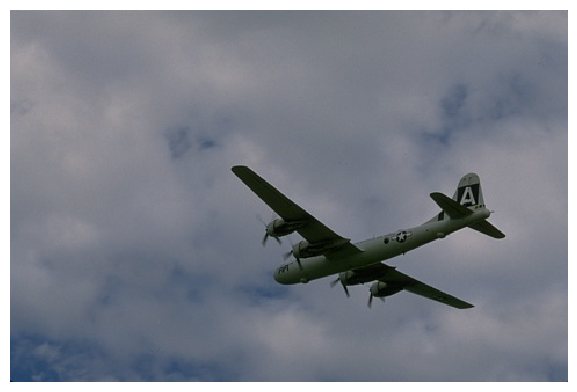

In [129]:
plt.matshow(matrix, cmap='gray')
plt.axis('off')
plt.show()

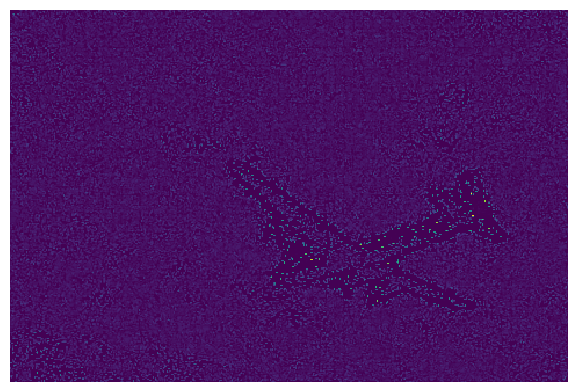

In [134]:
plt.matshow(bounds_array, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

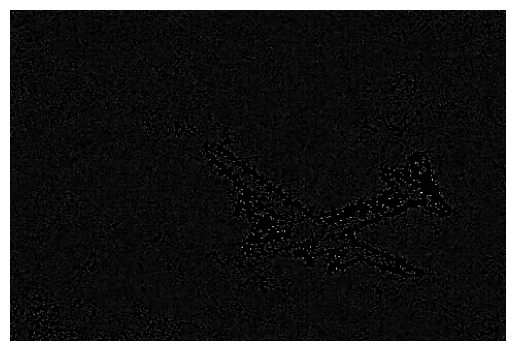

In [135]:
plt.imshow(bounds_array, cmap='gray')
plt.axis('off')
plt.show()